In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.datasets
import utils

from nn_framework.op import Variable, Const, Placeholder, ReLU, Sigmoid, GradientDescentOptimizer, Ones, LogisticLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
class Session(object):
  def run(self, expressions, feeds={}):
    cache = {}
    return [exp.eval(feeds, cache) for exp in expressions]

In [3]:
def dense(X, input_dim, output_dim):
  W = Variable(np.random.randn(output_dim, input_dim) * 0.01)
  b = Variable(np.zeros([output_dim, 1]))
  return W.dot(X) + b

X.shape = (2, 1000), Y.shape = (1, 1000)


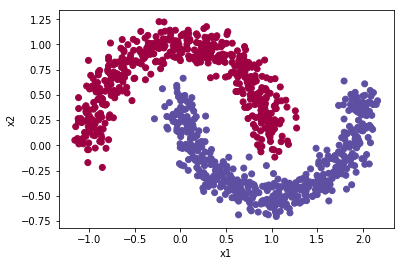

In [4]:
# m = 100
# X = np.ones([2, m]) + 10
# X[:, m // 2:] += 10
# X += np.random.randn(X.shape[0], X.shape[1]) * 3
# Y = np.hstack([np.zeros((1, m // 2)), np.ones((1, m // 2))])
# X /= 25

X, Y = sklearn.datasets.make_moons(1000, noise=0.1)
X = X.T
Y = Y.reshape(-1, 1).T

print('X.shape = %s, Y.shape = %s' % (X.shape, Y.shape))
plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

In [5]:
# def dot_grads(var, a, b, name):
#   with tf.name_scope(name):
#     fill = tf.fill((n_h, m), 1.)
#     with tf.name_scope('matmul_grad'):
#       da_target = tf.matmul(fill, b, transpose_b=True)
#       db_target = tf.matmul(fill, a, transpose_a=True)
      
#     [da] = tf.gradients(a, [var], da_target, name='da')
#     [db] = tf.gradients(b, [var], tf.transpose(db_target), name='db')

#     if da is None:
#       return db
#     elif db is None:
#       return da
#     else:
#       return tf.add_n([da, db])

tf.reset_default_graph()
m = 1000
n = 20
n_h = 50

w = np.random.randn(n_h, n)
b = np.random.randn(n_h, 1)
t1 = np.random.randn(n, n_h)
t2 = np.random.randn(n, m)

# TensorFlow
wtf = tf.constant(w)
biastf = tf.constant(b)
atf = wtf * 2
atf *= atf
btf = (tf.matmul(t1, tf.matmul(wtf, t2)) + 1) * 2 - 3
btf *= btf

ztf = tf.matmul(atf, btf) + biastf ** 2
ztf *= ztf
[dwtf, dbtf] = tf.gradients(ztf, [wtf, biastf])

# My :D
wmy = Variable(w)
biasmy = Variable(b)
amy = wmy * Const(2)
amy *= amy
bmy = (Const(t1).dot(wmy.dot(Const(t2))) + Const(1)) * Const(2) - Const(3)
bmy *= bmy

zmy = amy.dot(bmy) + biasmy ** Const(2)
zmy *= zmy
dwmy, dbmy = zmy.deriv(wmy, Ones(zmy.shape)), zmy.deriv(biasmy, Ones(zmy.shape))

with tf.Session() as sess:
  [dwtf_val, dbtf_val] = sess.run([dwtf, dbtf])
  [dwmy_val, dbmy_val] = Session().run([dwmy, dbmy], {})
  
#   e = 1e-8 
#   dw_num = np.zeros(w.shape)
#   for r in range(w.shape[0]):
#     for c in range(w.shape[1]):
#       w_copy = np.copy(w)
#       w_copy[r, c] -= e
#       assign = wmy.assign(Const(w_copy))
#       [_, zm] = Session().run([assign, zmy])
      
#       w_copy = np.copy(w)
#       w_copy[r, c] += e
#       assign = wmy.assign(Const(w_copy))
#       [_, zp] = Session().run([assign, zmy])
      
#       dw_num[r, c] = (zp - zm) / (2 * e)
  
  assert dwtf_val.shape == dwmy_val.shape, 'dw shapes should match'
  assert dbtf_val.shape == dbmy_val.shape, 'db shapes should match'
  
  dw_mse = np.mean(np.square(dwtf_val - dwmy_val))
  db_mse = np.mean(np.square(dbtf_val - dbmy_val))
#   dw_num_mse = np.mean(np.square(dw_num - dwmy_val))
  
  print('actual test: dw mse: %s, db mse: %s' % (dw_mse, db_mse))

actual test: dw mse: 0.000773893654346, db mse: 3.38535102729e-13


In [6]:
learning_rate = 0.01
steps = 10000
log_interval = 500

A0 = Placeholder('X')
net = dense(A0, input_dim=X.shape[0], output_dim=16)
net = ReLU(net)
net = dense(net, input_dim=16, output_dim=16)
net = ReLU(net)
net = dense(net, input_dim=16, output_dim=16)
net = ReLU(net)
net = dense(net, input_dim=16, output_dim=8)
net = ReLU(net)
net = dense(net, input_dim=8, output_dim=1)  
net = Sigmoid(net)
Y_hat = net

loss = LogisticLoss(a=Y_hat, y=Const(Y))
train = GradientDescentOptimizer(learning_rate, loss)

sess = Session()
print('loss: %f' % sess.run([loss], {A0: X})[0])

for i in range(0, steps):
  _, l, Y_hat_val = sess.run([train, loss, Y_hat], {A0: X})
  if i % log_interval == 0:
    acc = np.mean(Y == (Y_hat_val > 0.5)) * 100
    print('step: %d, loss: %f, accuracy: %s' % (i, l, acc))

loss: 0.693147
step: 0, loss: 0.693147, accuracy: 50.0
step: 500, loss: 0.693147, accuracy: 50.1
step: 1000, loss: 0.693147, accuracy: 78.6
step: 1500, loss: 0.693147, accuracy: 76.9
step: 2000, loss: 0.693147, accuracy: 76.5
step: 2500, loss: 0.693147, accuracy: 76.6
step: 3000, loss: 0.693147, accuracy: 76.7
step: 3500, loss: 0.693147, accuracy: 76.6
step: 4000, loss: 0.693147, accuracy: 76.6
step: 4500, loss: 0.693147, accuracy: 76.7
step: 5000, loss: 0.693147, accuracy: 76.5
step: 5500, loss: 0.693147, accuracy: 76.7
step: 6000, loss: 0.693147, accuracy: 76.7
step: 6500, loss: 0.693147, accuracy: 76.8
step: 7000, loss: 0.693147, accuracy: 76.9
step: 7500, loss: 0.693147, accuracy: 76.7
step: 8000, loss: 0.693147, accuracy: 76.7
step: 8500, loss: 0.693147, accuracy: 76.7
step: 9000, loss: 0.693147, accuracy: 76.7
step: 9500, loss: 0.693147, accuracy: 76.8


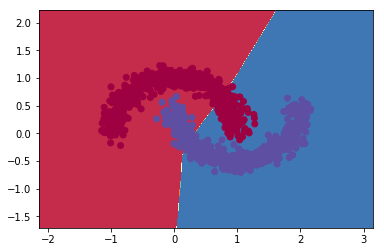

In [7]:
# TODO: remove self.grads and get them in optimizer

# utils.plot_decision_boundary(lambda X: , X, y, cmap=plt.cm.Spectral)
# plot_decision_boundary(lambda x: model.predict(x.T)[0] > 0.5, X, Y, cmap=plt.cm.Spectral)
utils.plot_decision_boundary(lambda x: sess.run([Y_hat], {A0: x.T})[0] > 0.5, X, Y, cmap=plt.cm.Spectral)
# utils.plot_decision_boundary(lambda x: print(x.T.shape), X, Y, cmap=plt.cm.Spectral)